In [1]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

fatal: destination path 'multimodal-memes' already exists and is not an empty directory.


**Get data from Kaggle**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"susannapaoli","key":"990ea74608e878a29ea3a7599a71e25f"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!pwd

/content


In [7]:
!kaggle datasets download -d parthplc/facebook-hateful-meme-dataset

100% 3.35G/3.35G [02:38<00:00, 21.7MB/s]
100% 3.35G/3.35G [02:38<00:00, 22.7MB/s]


In [8]:
!unzip /content/facebook-hateful-meme-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/img/49758.png      
  inflating: data/img/49762.png      
  inflating: data/img/49785.png      
  inflating: data/img/49786.png      
  inflating: data/img/49802.png      
  inflating: data/img/49805.png      
  inflating: data/img/49806.png      
  inflating: data/img/49807.png      
  inflating: data/img/49810.png      
  inflating: data/img/49826.png      
  inflating: data/img/49831.png      
  inflating: data/img/49832.png      
  inflating: data/img/49836.png      
  inflating: data/img/49850.png      
  inflating: data/img/49856.png      
  inflating: data/img/49861.png      
  inflating: data/img/49863.png      
  inflating: data/img/49867.png      
  inflating: data/img/49870.png      
  inflating: data/img/50124.png      
  inflating: data/img/50126.png      
  inflating: data/img/50129.png      
  inflating: data/img/50137.png      
  inflating: data/img/50142.png      
  inflating: data/img/50146.png      

In [2]:
!pip install -q transformers

In [3]:
'''
IMPORTING NECESSARY MODULES
'''

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

sys.path.append('/content/multimodal-memes/BERT')
sys.path.append('/content/multimodal-memes')
sys.path.append('/content/multimodal-memes/Utils')
sys.path.append('/content/multimodal-memes/Data')
sys.path.append('/content/multimodal-memes/Resnet')
sys.path.append('/content/multimodal-memes/Data/data/img')

from dataloader import myfusiondataset
#from Load_model import load
from plot_curves import plot_loss, plot_acc
from multimodal_trainer import train, test_classify

'''
For ResNet/ ResNeXt
'''
from resnet_model import ResNet,Bottleneck, resnext101_32x8d


'''
For BERT
'''
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

**Device**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Dataloading Scheme**

In [5]:
%cd /content/data

/content/data


In [6]:
trainlist = 'train.jsonl'
validlist = 'dev.jsonl'

In [7]:
'''
Train Dataloader
''' 
train_dataset = myfusiondataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=8,pin_memory=True)


'''
Validation Dataloader
''' 
validation_dataset = myfusiondataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 16, num_workers=8,pin_memory=True)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

**Model Definition**

In [8]:
'''
Model1 ResNeXt101_32x8d
'''
Image_model = resnext101_32x8d()

Image_model.fc = nn.Sequential(
    nn.Linear(Image_model.fc.in_features, 2)
    )

Image_model = nn.DataParallel(Image_model).to(device)

#Image_model.to(device)

In [9]:
'''
Model 2 BERT

Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
''' 

Text_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = True
)

Text_model = nn.DataParallel(Text_model).to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
'''
Fusion
'''
class FusionNet(nn.Module):
    
    def __init__(self, num_classes, drop_prob = 0.1):
        super(FusionNet, self).__init__()
        
        self.pooler = nn.Linear(in_features=768, out_features=768)
        
        self.concat = nn.Linear(in_features=768+2048, out_features= 512)
        
        self.bn = nn.BatchNorm1d(512)
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(2048)
    
        self.dropout = nn.Dropout(drop_prob)
        
        self.classify = nn.Linear(in_features = 512, out_features = num_classes)
        
        
    def forward(self, text_features, image_features):
        text_features = torch.tanh(self.pooler(text_features))
        text_features = self.dropout(text_features)

        text_features = self.bn1(text_features)
        image_features = self.bn2(image_features)
      
        fused =  torch.cat((text_features, image_features), dim=1)
      
        x = self.concat(fused)
  
        x = F.tanh(self.bn(x))          
  
        x = F.tanh(self.classify(x)) 
  

        return x



In [11]:
Fusion_model = FusionNet(num_classes =2 , drop_prob = 0.1)
Fusion_model = nn.DataParallel(Fusion_model).to(device)

**Hyperparameters**

In [12]:
'''
Loss Function
'''
criterion = nn.CrossEntropyLoss()


'''
Optimizer
'''
optimizer = torch.optim.SGD(Fusion_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)

'''
Number of training epochs.
'''
num_Epochs = 5

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma = 0.1)

In [13]:
model_name = 'Concatenation + BERT'
model_path = './saved_model_checkpoints/'+model_name

In [14]:
writer = SummaryWriter(model_name)

train_loss, v_loss, v_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.6330537203335225
Validation Loss: 0.8102	Validation Accuracy: 0.5520
Epoch:  2
training loss =  0.6062699917115664
Validation Loss: 0.8996	Validation Accuracy: 0.4980
Epoch:  3
training loss =  0.6225448555516121
Validation Loss: 0.9042	Validation Accuracy: 0.5160
Epoch:  4
training loss =  0.5933904968258134
Validation Loss: 0.8124	Validation Accuracy: 0.4960
Epoch:  5
training loss =  0.5832253138821825
Validation Loss: 0.7831	Validation Accuracy: 0.5060


**Evaluate on Validation set**

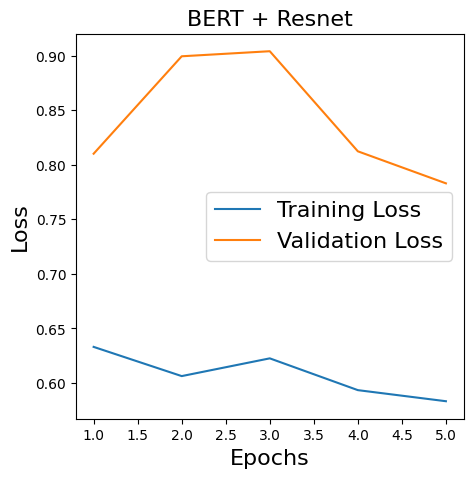

In [15]:
plot_loss(num_Epochs, train_loss, v_loss, 'BERT + Resnet')

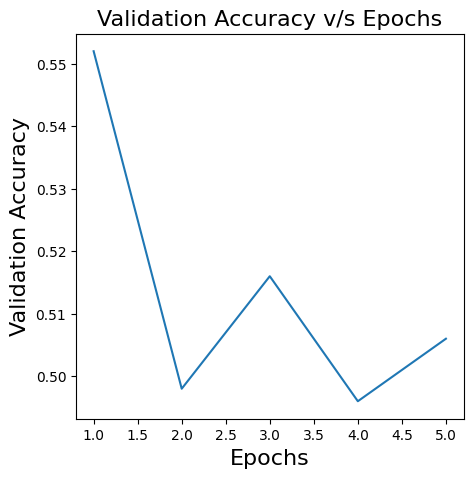

In [16]:
plot_acc(num_Epochs, v_acc)